# Problem Set 1 - K-Nearest Neighbor Classification and Regression
## CSCI 5622 - Spring 2023

For today's assignment, we will be implementing our own K-Nearest Neighbors classifier and regressor algorithms.

*But Professor Quigley, hasn't someone else already written KNN before?*

Yes, you are not the first to implement KNN, or basically any algorithm we'll work with in this class. But
1. I'll know that you know what's really going on
2. You'll know you can do it, because
    1. someday you might have to implement some machine learning algorithm from scratch - maybe for a new platform (do you need to run python on your SmartToaster just to get it to learn how users like their toast?), maybe because you want to tweak the algorithm (there's always a better approach...),
    2. maybe because you're working on something important, and you need to control exactly what's on there (should you really be running anaconda on your secret spy plane?).

That said - we're not going to implement *everything*. We'll start by importing a few helper functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.neighbors
import data
import helpers
%matplotlib inline

*Wait a minute - didn't we just import Scikit-learn (sklearn)? The package with baked-in machine learning tools?*
 Yes - but it also has a ton of helper functions that we'll be using later.

You will be guided through the different questions. You'll be expected to complete the classes and the functions following the provided signatures.

Remember to avoid adding positional arguments and make sure the returned values have the correct format (this applies to all assignments).
The alternative is that your solution might be rejected by the auto-grader (we won't be debugging your code during grading).
We will provide some basic sanity checks. They're in no means exhaustive and passing them does not imply that your solution is 100% correct.

For example, you're required to complete the method `compute_something` of class A.
We provide examples of acceptable solutions.

In [3]:
# This cell can be removed from the submitted notebook
class A:
    def compute_something(self) -> np.ndarray:
        """
        Returns: numpy array of zeros, with shape (4,)
        """
        # BEGIN
        answer = None
        # END
        return answer


class A1:  # Acceptable solution:
    # - the added y is an optional argument and omitting it does not affect the solution
    # - the returned object has the expected structure.
    def compute_something(self, y=None):
        # BEGIN
        return np.zeros((4,))
        # END


class A2:  # Wrong format:
    # - your solution requires a new positional argument y!: critical
    # - the returned object does not have the expected format!: critical
    # - solution outside the delimiters # BEGIN # END: makes grading easier
    def compute_something(self, y):
        return [0, 0, 0, 0]


class A3:  # Acceptable solution:
    # You're free to add your own helper functions/methods,
    # but they should be defined in the jupyter notebook (no external files)
    def compute_something(self):
        # BEGIN
        return self.get_zeros(4)
        # END

    def get_zeros(self, i):
        return np.zeros((i,))


First, let's also load a dataset to play with and start working to build out our own classifier.

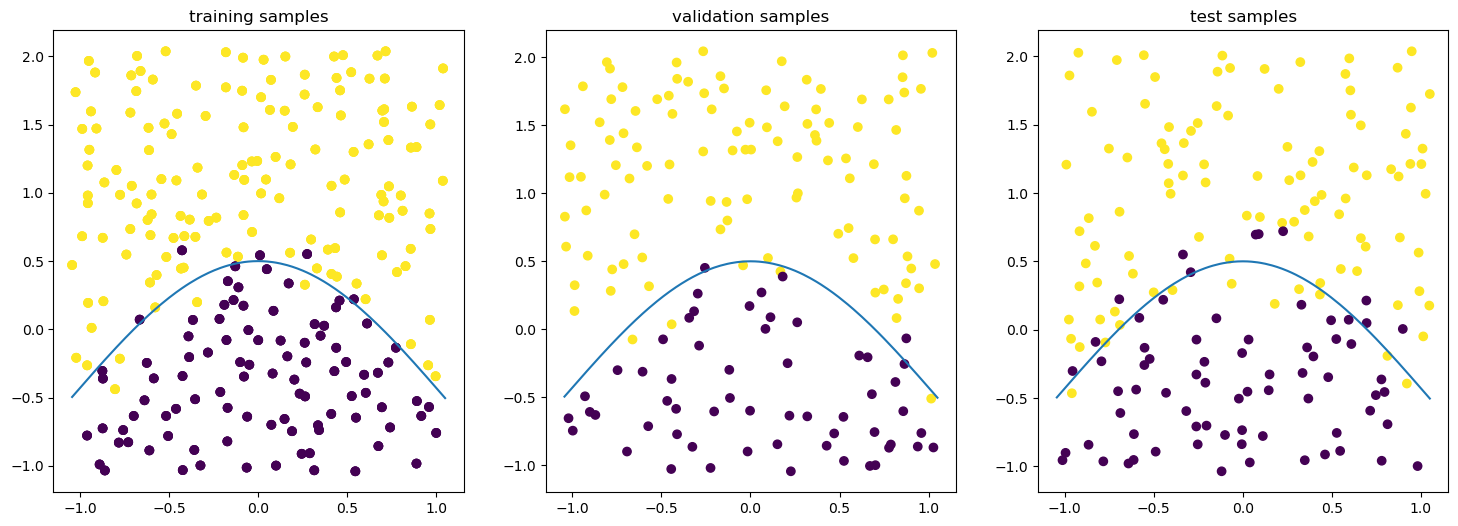

In [4]:
binary_data = data.BinaryData()
fig, axs = plt.subplots(1, 3)
fig.set_figheight(6), fig.set_figwidth(18)
for i, name in enumerate(["training", "validation", "test"]):
    axs[i].plot(*binary_data.boundary())
    axs[i].set_title("%s samples" % name)
    axs[0].scatter(binary_data.X_train[:, 0], binary_data.X_train[:, 1], c=binary_data.y_train)
axs[1].scatter(binary_data.X_valid[:, 0], binary_data.X_valid[:, 1], c=binary_data.y_valid)
axs[2].scatter(binary_data.X_test[:, 0], binary_data.X_test[:, 1], c=binary_data.y_test)
plt.show()

We have data! The `binary_data` instance has the following attributes:
   - a training set (`X_train, y_train`): to train the model and on which the prediction is based
   - a validation set (`X_valid, y_valid`): to select the best __hyper-parameters__ of the model
   - a test set (`X_test, y_test`): to evaluate the performance of the model on unseen data

### Problem 1: Complete our KNN Classifier - 40 Points + 10 Bonus


The KNNClassifier class we're implementing will have similar design to the [KNeighbors classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) from *scikit-learn*:
- Initialize the classifier with corresponding parameters (number of neighbors k)
- A `fit` method that uses the training data
- A `predict` method that returns the predicted labels given data `X`

We've written out a lot of the structure for you for consistency across different parts of the assignment and so
you can focus on the "important" stuff that actually relates to machine learning itself.


In [5]:
class KNNClassifier:

    def __init__(self, k=5):
        """ Initialize our custom KNN classifier
        Args:
            k: the number of nearest neighbors to consider for classification
        """
        self._k = k
        self._ball_tree = None
        self._y = None
        self.label_to_index = None
        self.index_to_label = None
        self.population_most_common = None

    def fit(self, X, y):
        """ Fit the model using the provided data
        Args:
            X:  matrix of shape (num_training_samples, num_features)
            y: array of shape (num_training_samples,)
        Returns: Fit instance of KNNClassifier (self)
        """
        self._ball_tree = sklearn.neighbors.BallTree(X)  # See documentation of BallTree and how it's used
        self._y = y
        # Should be used to map the classes to {0,1,..C-1} if needed (C is the number of classes)
        # We can assume that the training data contains samples from all the possible classes
        classes = np.unique(y)
        self.label_to_index = dict(zip(classes, range(classes.shape[0])))
        self.index_to_label = dict(zip(range(classes.shape[0]), classes))
        
        label_values, label_counts = np.unique(y, return_counts=True)
        self.training_most_common = label_values[np.argmax(label_counts)]

        return self

    def sample_label(self, index):
        # helper method to get label of sample index in majority_vote
        assert index < self._y.shape[0]
        return self._y[index]
    
    def find_nearest_labels(self, indices, distances):
        label_counts = {}
        index_to_distance = {}
        for index, distance in zip(indices, distances):
            label = self.sample_label(index)
            if label in label_counts:
                label_counts[label] += 1
            else:
                label_counts[label] = 0
            index_to_distance[index] = distance

        nearest_labels = [label for label, count in label_counts.items() if count == max(label_counts.values())]
        return nearest_labels, index_to_distance
        
        
    def majority_vote(self, indices_nearest_k, distances_nearest_k=None):
        """ Given indices of the nearest k neighbors for each point,
            report the majority label of those points.
        Args:
            k_nearest_indices: 2-d array of the indices of training neighbors, of shape (M, k)
            k_nearest_distances: 2-d array of the corresponding distances of training neighbors, of shape (M, k)
        Returns: The majority label for each row of indices, shape (M,)
        """

        # Workspace 1.2
        # TODO: Determine majority for each row of indices_nearest_k
        # TODO: if there is a tie, set the label to the most common label in the training set
        voted_labels = np.empty(indices_nearest_k.shape[0])  # to include
        # BEGIN 
        # code here
        for voted_label_index, indices, distances in zip(range(len(voted_labels)), indices_nearest_k, distances_nearest_k):
            # count votes for each label
            nearest_labels, index_to_distance = self.find_nearest_labels(indices, distances)
            # remove the farthest element
            while(len(nearest_labels) != 1):
                farthest_distance = max(index_to_distance.values())
                new_index_to_distance = {index:distance for index, distance in index_to_distance.items() if distance != farthest_distance}
                indices = list(new_index_to_distance.keys())
                distances = list(new_index_to_distance.values())
                nearest_labels, index_to_distance = self.find_nearest_labels(indices, distances)
    
            voted_labels[voted_label_index] = nearest_labels[0]
        # END
        return voted_labels

    def predict(self, X):
        """ Given new data points, classify them according to the training data
            provided in self.fit and number of neighbors self.k
            - You should use BallTree to get the distances and indices of
            the nearest k neighbors
        Args:
            X: feature vectors (num_samples, num_features)
        Returns:
            1-D array of predicted classes of shape (num_samples,)
        """
        # Workspace 1.1
        # inc distances_nearest_k, indices_nearest_k = None, None  # REPLACE
        # BEGIN 
        # code here
        distances_nearest_k, indices_nearest_k = self._ball_tree.query(X, self._k)
        # END
        return self.majority_vote(indices_nearest_k, distances_nearest_k)

    def confusion_matrix(self, X, y):
        """ Generate the confusion matrix for the given data
        Args:
            X: data matrix, shape (num_samples, num_features)
            y: the corresponding correct classes of our set, shape (num_samples,)
        Returns: a CxC matrix, where C is the number of classes in our training data
        """

        # The rows of the confusion matrix correspond to the counts from the true labels, the columns to the predictions'
        # Workspace 1.3
        # TODO: Run classification for the test set X, compare to test answers y, and add counts to matrix
        c_matrix = np.zeros((len(self.label_to_index), len(self.label_to_index)))
        # BEGIN 
        # code here
        y_hat = self.predict(X)
        for i in range(len(y_hat)):
            c_matrix[self.label_to_index[y[i]], self.label_to_index[y_hat[i]]] += 1
        # END
        return c_matrix

    def accuracy(self, X, y):
        """ Return the accuracy of the classifier on the data (X, y)
        Args:
            X: matrix of shape (num_samples, num_features)
            y: array of shape (num_samples,)

        Returns: accuracy score [float in (0,1)]
        """
        # Workspace 1.4
        # TODO: Compute accuracy on X
        # inc score = 0
        # BEGIN 
        # code here
        # END
        correct = 0
        y_hat = self.predict(X)
        for prediction, target in zip(y_hat, y):
            if prediction == target:
                correct += 1
        score = correct / len(y)
        return score

In [6]:
# Test cell, uncomment to run the tests
%run -i tests knnc

....
----------------------------------------------------------------------
Ran 4 tests in 0.007s

OK


<Figure size 640x480 with 0 Axes>

*But professor, this code isn't complete!*



**Q1.1** *[5 points]*  Complete the `predict` function to report the predicted class of a new datapoint based on the result of the `majority_vote` function.

 - HINT: Use the [BallTree documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree) to determine how to retrieve neighbors from the model

**Q1.2** *[8 points]*  Complete the `majority_vote` function to determine the majority class of a series of neighbors.
    If there is a tie, then you should remove the farthest element until the tie is broken.

**Q1.3** *[7 points]*  Complete the `confusion_matrix` function to reveal the results of classification

**Q1.4** *[5 points]*  Complete the `accuracy` function to get accuracy of the classifier based on a given test data

Below, we'll be using our KNNClassifier (sent in as "model") to show how we would predict any points in space given the input data.

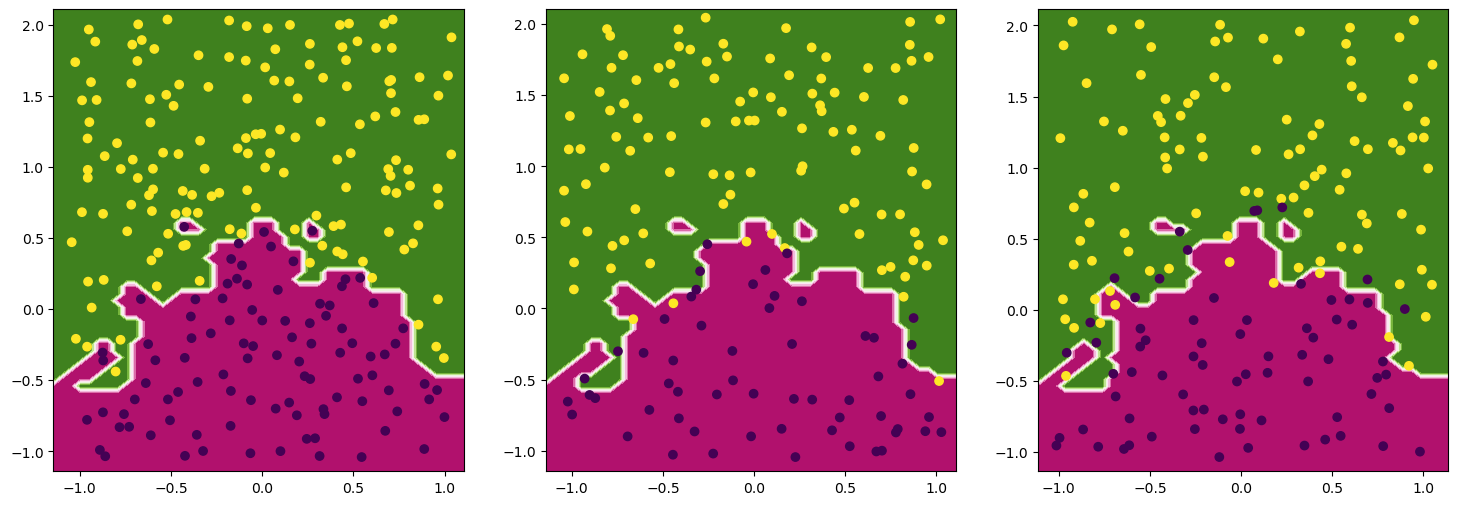

In [7]:
# This cell is to show the decision surface of the classifier
# You can change k to visualize KNN behavior
knn = KNNClassifier(2).fit(binary_data.X_train, binary_data.y_train)
fig, axs = plt.subplots(1, 3)
fig.set_figheight(6), fig.set_figwidth(18)
helpers.show_decision_surface(knn, binary_data.X_train, binary_data.y_train, axs[0])
helpers.show_decision_surface(knn, binary_data.X_valid, binary_data.y_valid, axs[1])
helpers.show_decision_surface(knn, binary_data.X_test, binary_data.y_test, axs[2])
plt.show()

**Q1.5** *[10 points]*  For each k in the range [1,32], fit a KNNClassifier on the training set and plot the accuracies on training and validation data versus k.

What's the value of k that yields the best accuracy on the training set? on the validation set? Which one should we choose?

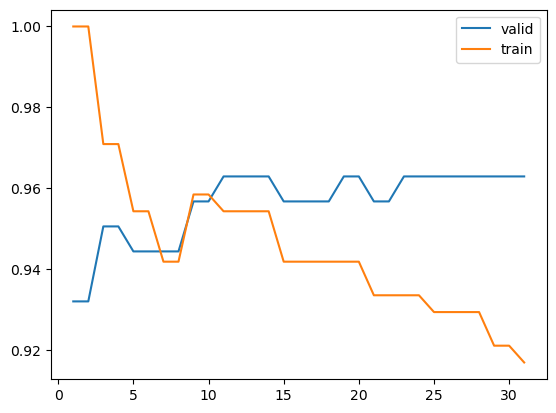

In [8]:
# Workspace 1.5.a
#TODO: Try different Ks
ks = list(range(1, 32))
accuracies_train = []
accuracies_valid = []
for k in ks:
    # BEGIN 
    # code here
    knn_k = KNNClassifier(k).fit(binary_data.X_train, binary_data.y_train)
    train_accuracy = knn_k.accuracy(binary_data.X_train, binary_data.y_train)
    valid_accuracy = knn_k.accuracy(binary_data.X_valid, binary_data.y_valid)
    accuracies_train.append(train_accuracy)
    accuracies_valid.append(valid_accuracy)
    
    # END
plt.plot(ks, accuracies_valid, label="valid")
plt.plot(ks, accuracies_train, label="train")
plt.legend()
plt.show()

### # Workspace 1.5.b
% Write up: best k for training and validation and which one should we choose

The best k for training is 1, but we need to avoid it because it's overfitting.
The best k for validation is 11, it has the highest accuracy.

**Q1.6** *[5 points]*  Report the accuracy and the confusion matrix on the test set using the value of k chosen in 1.5

In [9]:
# Workspace 1.6
# TODO: compute and print the accuracy on the test set using k from 1.5
# inc best_k = None
# BEGIN 
# code here
best_k = 11
knn_k = KNNClassifier(best_k).fit(binary_data.X_train, binary_data.y_train)
test_accuracy = knn_k.accuracy(binary_data.X_test, binary_data.y_test)
test_confusion_matrix = knn_k.confusion_matrix(binary_data.X_test, binary_data.y_test)

print("The test accuracy with key = 11 is {}".format(test_accuracy))
print("The test confusion matrix with key = 11 is ")
print(test_confusion_matrix)
# END

The test accuracy with key = 11 is 0.8901734104046243
The test confusion matrix with key = 11 is 
[[60. 11.]
 [ 8. 94.]]


**Bonus (for the avid machine learner) (10 Points)**

1.7.a [3 point] A [__consistent classifier__](https://proceedings.neurips.cc/paper/1996/file/7bb060764a818184ebb1cc0d43d382aa-Paper.pdf)
on the training data is defined as a classifier that reaches 100% accuracy on the training set. For which values of k is KNNClassifier Consistent?

1.7.b [7 points] Edit your `KNNClassifier` so that it's consistent for all $k$ (we made sure that the change do not affect the sanity checks)

#### Write-up for the bonus
**Workspace 1.7.a**

% for which k in KNNClassifier consistent

% BEGIN

% YOUR ANSWER HERE

% END

***
OK - now we've demonstrated that our KNN classifier works, let's think about our problem space!

## Problem 2: Improving KNN on Digits dataset - 20 Points

It's a pretty common problem - just imagine working at the post office, and you're handed a hand-written check,
and you have to identify exactly what it says.
Did they pay 500 or 600 dollars? Is the letter going to 80309 (campus) or 30309 (Atlanta)?

**Q2.1** *[5 points]* Complete `prepare_data` by reporting the number of examples in different partitions of the digits dataset and the number of pixels in the images. You also have to reshape `X_train, X_valid, X_test` arrays as matrices for our KNNClassifier to use them.

Note: the question is simple and straight-forward, there is no trick here,



In [10]:
digit_data = data.DigitData()

In [11]:
def prepare_data(dataset: data.Dataset):
    """
    Report information about the dataset using the print() function and reshape X_? to 2-d arrays
    """
    # Workspace 2.1
    # BEGIN 
    # code here
    dataset.X_train = dataset.X_train.reshape(dataset.X_train.shape[0], (dataset.X_train.shape[1]*dataset.X_train.shape[2]))
    print("train dataset has {} digits and the number of pixels in the images is {}"
          .format(str(dataset.X_train.shape[0]), str(dataset.X_train.shape[1])))
    label_values, label_counts = np.unique(digit_data.y_train, return_counts=True)
    print("y_train has the following labels: ")
    for value, count in zip(label_values, label_counts):
        print("value: {}, count: {}".format(value,count))
    
    dataset.X_valid = dataset.X_valid.reshape(dataset.X_valid.shape[0], (dataset.X_valid.shape[1]*dataset.X_valid.shape[2]))
    print("\n")
    print("valid dataset has {} digits and the number of pixels in the images is {}"
          .format(str(dataset.X_valid.shape[0]), str(dataset.X_valid.shape[1])))
    label_values, label_counts = np.unique(digit_data.y_valid, return_counts=True)
    print("y_valid has the following labels: ")
    for value, count in zip(label_values, label_counts):
        print("value: {}, count: {}".format(value,count))
    
    dataset.X_test = dataset.X_test.reshape(dataset.X_test.shape[0], (dataset.X_test.shape[1]*dataset.X_test.shape[2]))
    print("\n")
    print("test dataset has {} digits and the number of pixels in the images is {}"
          .format(str(dataset.X_test.shape[0]), str(dataset.X_test.shape[1])))
    label_values, label_counts = np.unique(digit_data.y_test, return_counts=True)
    print("y_t has the following labels: ")
    for value, count in zip(label_values, label_counts):
        print("value: {}, count: {}".format(value,count))
    
    # END

In [12]:
prepare_data(dataset=digit_data)

train dataset has 2625 digits and the number of pixels in the images is 784
y_train has the following labels: 
value: 0, count: 294
value: 1, count: 289
value: 2, count: 255
value: 3, count: 268
value: 4, count: 257
value: 5, count: 224
value: 6, count: 280
value: 7, count: 281
value: 8, count: 250
value: 9, count: 227


valid dataset has 1125 digits and the number of pixels in the images is 784
y_valid has the following labels: 
value: 0, count: 102
value: 1, count: 127
value: 2, count: 112
value: 3, count: 136
value: 4, count: 88
value: 5, count: 102
value: 6, count: 110
value: 7, count: 110
value: 8, count: 115
value: 9, count: 123


test dataset has 1250 digits and the number of pixels in the images is 784
y_t has the following labels: 
value: 0, count: 114
value: 1, count: 147
value: 2, count: 138
value: 3, count: 111
value: 4, count: 116
value: 5, count: 108
value: 6, count: 129
value: 7, count: 135
value: 8, count: 118
value: 9, count: 134


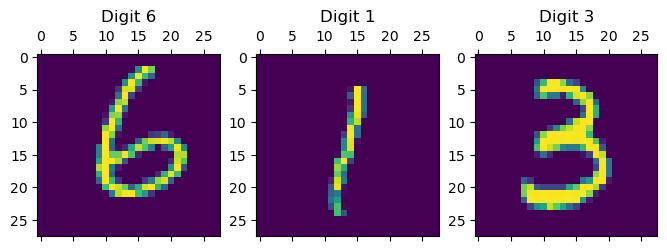

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(8, 24))
helpers.view_digit(digit_index=1,dataset = digit_data, partition="test", ax=ax[0])
helpers.view_digit(digit_index=5,dataset = digit_data, partition="test", ax=ax[1])
helpers.view_digit(digit_index=5,dataset = digit_data, partition="valid", ax=ax[2])
plt.show()

Now we want to automatically perform the model selection from 1.5, 1.6


**Q2.2** *[10 points]* complete the `evaluate` to perform the same evaluation we did in 1.5:
 - For k in range (1, 20):
    - initialize the classifier for k  and train in on the training set
    - Compute the accuracy on the validation set and save it
 - Choose k with the best accuracy on the validation set
 - Report the accuracy and the confusion matrix on the test set (use `display_confusion` for a cleaner output)


In [14]:
def evaluate(ks_range,dataset: data.Dataset, KNNClass=KNNClassifier):
    """ Evaluate KNNClassifier of Dataset for k in ks_range by printing the accuracy and confusion matrix of the best k
    Args:
        ks_range: range of k values
        dataset: dataset
    """
    # Workspace 2.2
    # inc best_valid_k = None
    # inc confusion_matrix = None
    # inc accuracy = 0
    ks = ks_range
    accuracies_valid = []
    
    best_valid_k = ks[0]
    for k in ks:
        print(k, end="\r")
        # BEGIN 
        # code here
        knn_k = KNNClass(k).fit(dataset.X_train, dataset.y_train)
        valid_accuracy = knn_k.accuracy(dataset.X_valid, dataset.y_valid)
        accuracies_valid.append(valid_accuracy)
        
        # END
    # list index starts from 0 so need to add 1
    best_valid_k = accuracies_valid.index(max(accuracies_valid)) + 1
    knn_k = KNNClass(best_valid_k).fit(dataset.X_train, dataset.y_train)
    accuracy = knn_k.accuracy(dataset.X_test, dataset.y_test)
    confusion_matrix = knn_k.confusion_matrix(dataset.X_test, dataset.y_test)
    print("best k:", best_valid_k)
    print("Accuracy on test set:", accuracy)
    helpers.display_confusion(confusion_matrix)


In the next cell, we run the evaluation on k in the range ${2...9}$.

best k: 2
Accuracy on test set: 0.92


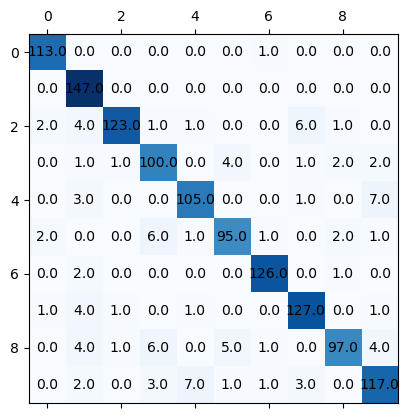

Wall time: 31.9 s


In [15]:
%%time
evaluate(range(2, 10), digit_data)

**Q2.3** [5 points] Determine which classes are most often confused (from our confusion matrix above).
Display examples (at least 3) of **misclassified test instances** and explain why the KNNClassifier might have missed them.

accuracy of 0: 0.9912280701754386
accuracy of 1: 1.0
accuracy of 2: 0.8913043478260869
accuracy of 3: 0.9009009009009009
accuracy of 4: 0.9051724137931034
accuracy of 5: 0.8796296296296297
accuracy of 6: 0.9767441860465116
accuracy of 7: 0.9407407407407408
accuracy of 8: 0.8220338983050848
accuracy of 9: 0.8731343283582089
[8 9 5]


<Figure size 640x480 with 0 Axes>

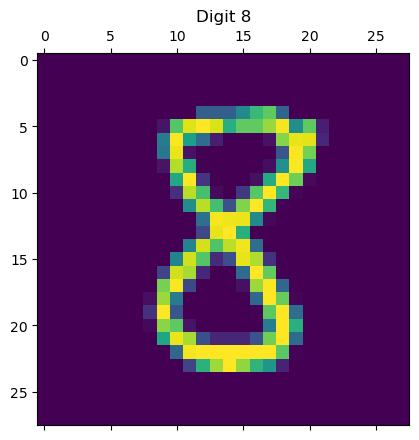

<Figure size 640x480 with 0 Axes>

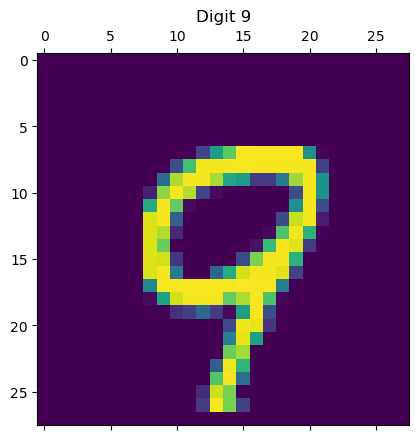

<Figure size 640x480 with 0 Axes>

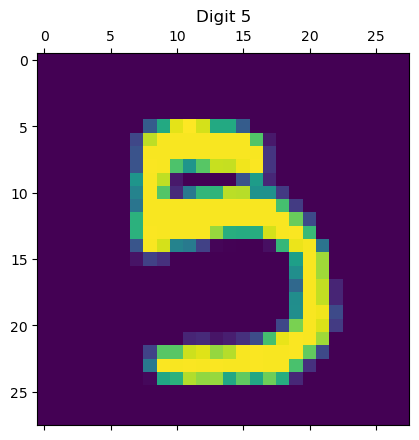

In [16]:
# Workspace 2.3.a
#TODO: Print out problem class images
# BEGIN 
# code here
best_valid_k = 2
knn_k = KNNClassifier(best_valid_k).fit(digit_data.X_train, digit_data.y_train)
accuracy = knn_k.accuracy(digit_data.X_test, digit_data.y_test)
confusion_matrix = knn_k.confusion_matrix(digit_data.X_test, digit_data.y_test)


label_values, label_counts = np.unique(digit_data.y_test, return_counts=True)
accuracy_for_each_class = []
for i in range(len(label_values)):
    accuracy = confusion_matrix[i][i] / label_counts[i]
    accuracy_for_each_class.append(accuracy)
    print("accuracy of {}: {}".format(str(i), str(accuracy)))
    
most_often_confused_classes= np.argsort(accuracy_for_each_class)[: 3]
print(most_often_confused_classes)
helpers.view_digit(digit_index=6,dataset = digit_data, partition="test")
helpers.view_digit(digit_index=3,dataset = digit_data, partition="test")
helpers.view_digit(digit_index=9,dataset = digit_data, partition="test")
# END

**Workspace 2.3.b**

TODO: Write description of mis-classification

% BEGIN

% YOUR ANSWER HERE
 explain why the KNNClassifier might have missed them.

The most often confused classes are 8, 9, 5 because they have the highest error rate. The KNNClassifier might have misclassified 8 because there are classes that look like 8. From the confusion matrix, 8 was most likely to be misclassified into 3, 5, and 9 because they have many features in common. From the confusion matrix, 9 was misclassified into 4 and 5 was misclassfieid into 3 because the target classes and the misclassified classes have many features in common. 

% END

## Problem 3 - KNNRegressor [20 points]
***
Let's consider a different problem - Regression. Regression deals with continuous target values (labels).
For this problem we'll use the [California Housing Prices dataset](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset)

Features matrix shape: (13209, 8)


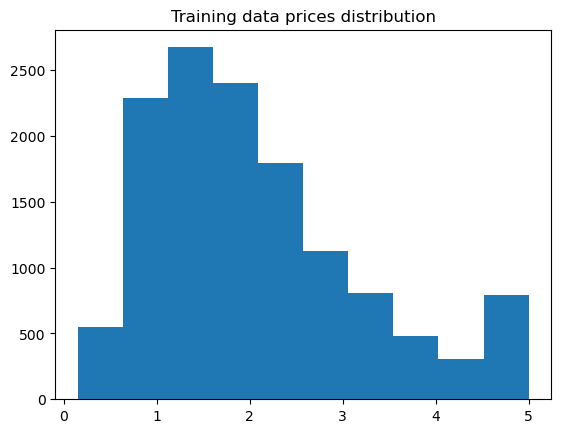

In [17]:
housing_data = data.HousingPrices()
print("Features matrix shape:", housing_data.X_train.shape)
plt.title("Training data prices distribution")
plt.hist(housing_data.y_train)
plt.show()

The KNNRegressor(k) predicts the target value by uniformly averaging the target values of the k-nearest neighbors from the training data.

**Q3.1** [7 points]  Complete `average_vote` function

**Q3.2** [7 points]  Complete the `mse` function. Do not use sklean built-in functions (only numpy functions).

In [18]:
class KNNRegressor(KNNClassifier):

    def get_average_y_value(self, indices_nearest_k):
        sum = 0
        for i in indices_nearest_k:
            sum += self.sample_label(i)

        average = sum/len(indices_nearest_k)
        return average
        
        
    def average_vote(self, indices_nearest_k, distances_nearest_k=None):
        """ Given indices of the nearest k neighbors for each point, report the average y value of those points.
        Args:
            indices_nearest_k: np.array containing the indices of training neighbors, of shape (M, k)
            distances_nearest_k: np.array containing the corresponding distances of training neighbors,
            of shape (M, k), for the bonus
        Returns:The majority label for each row of indices, shape (M,)
        """

        # Workspace 3.1
        # TODO: Calculate the average y value for each set of neighbors and store in voted_labels
        voted_labels = np.empty(indices_nearest_k.shape[0])  # to include
        # BEGIN 
        # code here
        for index in range(len(voted_labels)):
            # calculate the average y value 
            voted_labels[index] = self.get_average_y_value(indices_nearest_k[index])
           
        return voted_labels


    def predict(self, X):
        distances_nearest_k, indices_nearest_k = self._ball_tree.query(X, k=self._k)
        return self.average_vote(indices_nearest_k, distances_nearest_k)

    def mse(self, X, y):
        """
         Return the Mean Squared Error of the classifier
        Args:
            X: np.array of shape (m, number_features)
            y: np.array of shape (m,)
        Returns:MSE  (y, y_hat)
        """

        # Workspace 3.2
        # TODO: Compute mse across all samples
        score = 0
        # BEGIN 
        # code here
        y_hat = self.predict(X)
        score = sum((y - y_hat) ** 2) / len(y)
        # END
        return score

**Q3.3** [6 points] Similar to 1.5, for each k in the range [1,32], fit a KNNRegressor on the training set and plot the Mean Squared Errors on training and validation data versus k.

What's the value of k that yields the best mse on the training set? on the validation set? Which k should we choose?


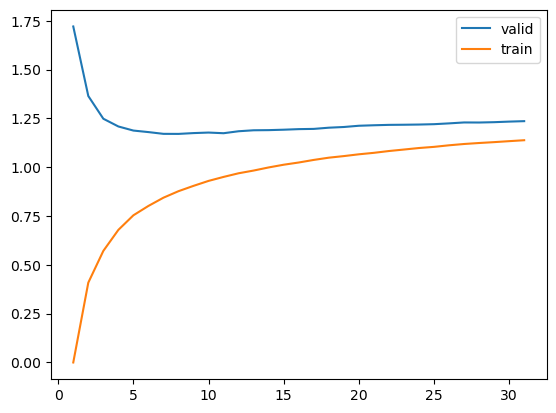

In [19]:
# Workspace 3.3.a
#TODO: Try different Ks
ks = list(range(1, 32))
accuracies_train = []
accuracies_valid = []
for k in ks:
    # BEGIN 
    # code here
    knn_k = KNNRegressor(k).fit(housing_data.X_train, housing_data.y_train)
    train_mse = knn_k.mse(housing_data.X_train, housing_data.y_train)
    valid_mse = knn_k.mse(housing_data.X_valid, housing_data.y_valid)
    accuracies_train.append(train_mse)
    accuracies_valid.append(valid_mse)
    # END
plt.plot(ks, accuracies_valid, label="valid")
plt.plot(ks, accuracies_train, label="train")
plt.legend()
plt.show()

In [20]:
best_train_k = accuracies_train.index(min(accuracies_train)) + 1
best_valid_k = accuracies_valid.index(min(accuracies_valid)) + 1

print("best k for train dataset: {} with mse: {}".format(str(best_train_k), str(accuracies_train[best_train_k-1])))
print("best k for valid dataset: {} with mse: {}".format(str(best_valid_k), str(accuracies_valid[best_valid_k-1])))

best k for train dataset: 1 with mse: 0.0
best k for valid dataset: 8 with mse: 1.1703406403689565


In [21]:
print(max(housing_data.y_valid))
print(min(housing_data.y_valid))

5.00001
0.14999


#### Workspace 3.3 writeup

best k for train dataset: 1 with mse: 0.0, however we need to avoid using k = 1 because is has 0 mse which means 100% accuracy. It's definetly overfitting.  
best k for valid dataset: 8 with mse: 1.1703406403689565. For valid dataset, k = 8 has the lowest mse. I think we should use k = 8, but it's not a good model because mse = 1.17 is not good when max and min values of y_valid are 5.00001 and 0.14999. 



### Problem 4 : Improving KNN on Binary and MNIST using WeightedKNN (20 pts)
Complete the `WeightedKNNClassifier` class to perform the weighted KNN classification.
The Weighted KNN classifier assigns weights to the nearest-neighbor training examples proportional to
 the inverse-distance from the training example to the query point.

Classification is performed by summing the weights associated with each class and predicting the class with the highest weighted-majority vote.
 Mathematically, we might describe the weighted-vote for a class $c$ as

\begin{align}
\textrm{Weighted-Vote}(c)(x) = \sum_{i \in {\cal N}_K(x)} I(y_i \in c) \times \frac{1}{\|{\bf x}_i - {\bf x}\|}
\end{align}

where ${\cal N}_K(x)$ is the set of the nearest $k$ neighbors to $x$.

**Q4.1** *[10 points]* Complete `weighted_vote`: it's certainly possible that a query point could be distance $0$ away from some training example.

 If this happens your implementation should handle it and return the appropriate class label.


In [22]:
import math 

class WeightedKNNClassifier(KNNClassifier):

    def calculate_weight(self, indices, distances, group_weights):
        for index, distance in zip(indices, distances):
            label = self.sample_label(index)
            if distance == 0:
                distance = 0.000001
            group_weights[label] += (1/distance)
    
        return group_weights 
        

    def weighted_vote(self, indices_nearest_k, distances_nearest_k):
        """ Given indices of nearest neighbors in training set, return the majority label.
        Break ties by considering 1 fewer neighbor until a clear winner is found.
        Args:
            indices_nearest_k: The indices of the K nearest neighbors in self.X_train
            distances_nearest_k: Corresponding distances from query point to K nearest neighbors.
        Returns: predicted labels
        """

        # Workspace 4.1
        labels = np.empty(indices_nearest_k.shape[0])  #You can replace
        # BEGIN 
        # code here
        groups = list(self.label_to_index.keys())
        for i in range(len(labels)):
            winner = None
            group_weights = {key: 0 for key in groups}
            
            indices = indices_nearest_k[i]
            distances = distances_nearest_k[i]
            group_weights = self.calculate_weight(indices, distances, group_weights)
            winners = [key for key, value in group_weights.items() if value == max(group_weights.values())]
            # if there is a tie, cosider 1 fewer neigbor until a clear winner is found
            while(len(winners) != 1):
                # k = k - 1
                lastElementIndex = len(indices)-1
                indices = indices[:lastElementIndex]
                distances = distances[:lastElementIndex]
                group_weights = self.calculate_weight(indices, distances, group_weights)    
                winners = [key for key, value in group_weights.items() if value == max(group_weights.values())]
            
            labels[i] = winners[0]
                
            
        # END

        return labels

    def predict(self, X):
        """ Given an np.array of query points, return y_hat, an np.array of predictions
        Args:
            X: an (m x p) dimension np.array of points to predict labels for
        Returns: predicted labels
        """

        distances_nearest_k, indices_nearest_k = self._ball_tree.query(X, k=self._k)
        labels = self.weighted_vote(indices_nearest_k, distances_nearest_k)
        return labels

In [23]:
# Test cell, uncomment to run the tests
%run -i tests weightedknnc

..
----------------------------------------------------------------------
Ran 2 tests in 0.005s

OK


<Figure size 640x480 with 0 Axes>

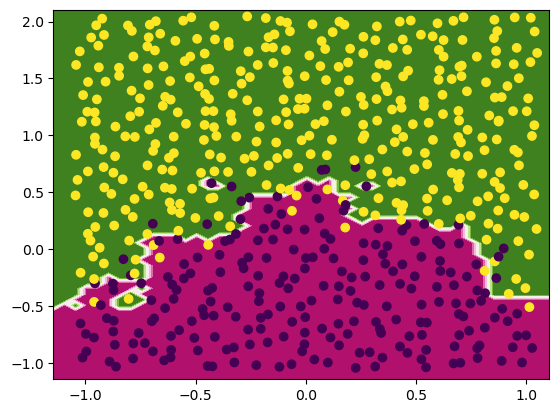

In [24]:
# Example on how to use the show_decision_surface
knn = WeightedKNNClassifier(3).fit(binary_data.X_train, binary_data.y_train)
helpers.show_decision_surface(knn, binary_data.X, binary_data.y)

**Q4.2** *[5 points]*Evaluate `WeightedKNNClassifier` on the binary data (use `evaluate` function)

best k: 20
Accuracy on test set: 0.884393063583815


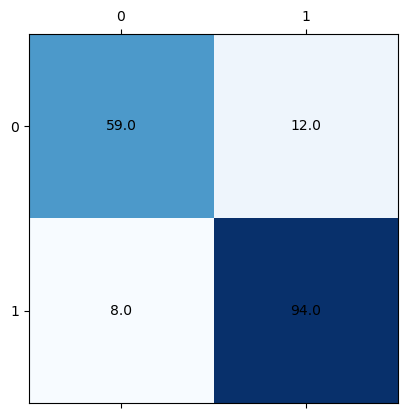

best k: 10
Accuracy on test set: 0.8901734104046243


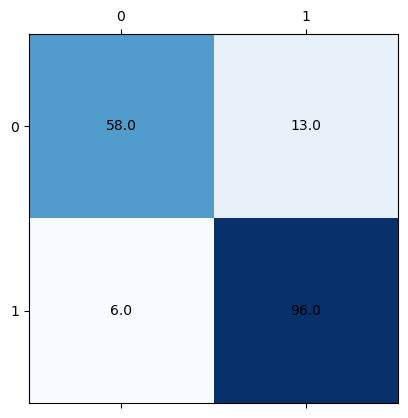

In [25]:
# Workspace 4.2
# BEGIN 
# code here
evaluate(range(2, 32), binary_data, WeightedKNNClassifier)
evaluate(range(2, 32), binary_data, KNNClassifier)
# END

### # Workspace 4.2.b
% Write up: Which classifier does better on the binary data

% BEGIN

% YOUR ANSWER HERE

KNNClassifier has higher accuracy than WeightedKNNClassifier on the binary data

% END


**Q4.3** *[5 points]* Compare `WeightedKNNClassifier` to `KNNClassifier` on the digits (MNIST) data using `Numbers` class.

best k: 2
Accuracy on test set: 0.92


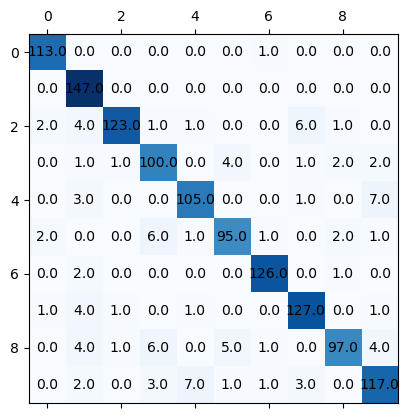

best k: 2
Accuracy on test set: 0.92


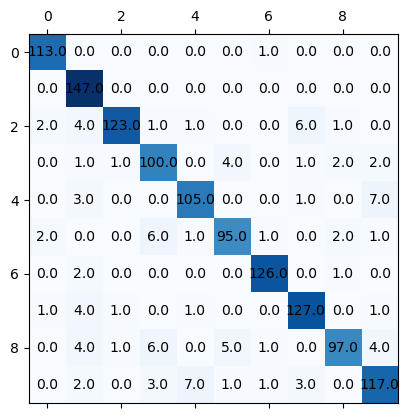

In [26]:
#Workspace 4.3.a
# BEGIN 
# code here
evaluate(range(2, 32), digit_data, WeightedKNNClassifier)
evaluate(range(2, 32), digit_data, KNNClassifier)
# END


### # Workspace 4.3.b
% Write up: Which classifier does better on the MNIST data

% BEGIN

% YOUR ANSWER HERE

Both WeightedKNNClassifier and KNNClassifier have the same and highest accuracy when k = 2

% END